In [1]:
%matplotlib inline

In [63]:
import os
import pickle
from glob import glob
import pandas as pd
import numpy as np
import nibabel as nb
from nighres.io import io_mesh
import matplotlib.pyplot as plt
import h5py
from scipy.stats import stats
import gdist
import seaborn as sns
from statsmodels.stats.multitest import multipletests

In [3]:
mesh = io_mesh.load_mesh('/home/julia/data/gradients/atlas/allen_api/regions/annot_finest.vtk')
cortex = np.where(mesh['data']!=0)[0]
hpc_mesh = io_mesh.load_mesh("/home/julia/data/gradients/results/distance/hippocampus_sampled_mesh.vtk")
piri_mesh = io_mesh.load_mesh("/home/julia/data/gradients/results/distance/piriform_sampled_mesh.vtk")
gradients_mesh = io_mesh.load_mesh('/home/julia/data/gradients/results/embedding_vol/embed_sampled_mesh.vtk')

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2455: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2458: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


### Distance from two origins

In [5]:
source = np.where(hpc_mesh['data']>0)[0]
dist = gdist.compute_gdist(np.array(mesh['points'], dtype=np.float64), 
                           np.array(mesh['faces'], dtype=np.int32), 
                           source_indices=np.array(source, dtype=np.int32),
                           target_indices=np.array(cortex, dtype=np.int32))
dist[dist==np.inf] = 0
dist_mesh = np.zeros_like(mesh['data'])
dist_mesh[cortex] = dist[:,np.newaxis]
io_mesh.save_mesh('/home/julia/data/gradients/results/distance/hippocampus_dist.vtk', 
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist_mesh})

In [6]:
source = np.where(piri_mesh['data']>0)[0]
dist = gdist.compute_gdist(np.array(mesh['points'], dtype=np.float64), 
                           np.array(mesh['faces'], dtype=np.int32), 
                           source_indices=np.array(source, dtype=np.int32),
                           target_indices=np.array(cortex, dtype=np.int32))
dist[dist==np.inf] = 0
dist_mesh = np.zeros_like(mesh['data'])
dist_mesh[cortex] = dist[:,np.newaxis]
io_mesh.save_mesh('/home/julia/data/gradients/results/distance/piriform_dist.vtk', 
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist_mesh})

In [7]:
hpc_dist = io_mesh.load_mesh('/home/julia/data/gradients/results/distance/hippocampus_dist.vtk')['data']
piri_dist = io_mesh.load_mesh('/home/julia/data/gradients/results/distance/piriform_dist.vtk')['data']

In [17]:
dist_combined = np.zeros_like(mesh['data'])
dist_combined[cortex] = - hpc_dist[cortex] + piri_dist[cortex]
io_mesh.save_mesh('/home/julia/data/gradients/results/distance/combined_dist.vtk', 
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist_combined})

In [7]:
dist_combined=io_mesh.load_mesh('/home/julia/data/gradients/results/distance/combined_dist.vtk')['data']

In [10]:
r_values = []
p_values = []
for g in range(6):
    r, p = stats.spearmanr(dist_combined[cortex], gradients_mesh['data'][:,g][cortex])
    r_values.append(r)
    p_values.append(p)

In [12]:
reject_0, p_corr, _, _ = multipletests(p_values, alpha=0.01, method='fdr_bh')

In [14]:
for g in range(6):
    if reject_0[g] == True:
        print('Gradient %i' %g, 'r=%f'%r_values[g], 'p_corr=%f'%p_corr[g])

Gradient 0 r=0.812273 p_corr=0.000000
Gradient 1 r=0.035297 p_corr=0.000145
Gradient 2 r=-0.033269 p_corr=0.000291
Gradient 3 r=-0.300303 p_corr=0.000000
Gradient 4 r=-0.624844 p_corr=0.000000
Gradient 5 r=0.111475 p_corr=0.000000


### Zones

In [13]:
zones_mesh = np.zeros_like(mesh['data'])
zones_mesh[hpc_dist < piri_dist] = 1
zones_mesh[hpc_dist > piri_dist] = -1
io_mesh.save_mesh('/home/julia/data/gradients/results/distance/zones.vtk', 
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':zones_mesh})


In [18]:
zones = io_mesh.load_mesh('/home/julia/data/gradients/results/distance/zones.vtk')
masked_zones = np.squeeze(zones['data'][cortex])
piri_zone = gradients_mesh['data'][:,0][cortex][masked_zones==-1]
hpc_zone = gradients_mesh['data'][:,0][cortex][masked_zones==1]

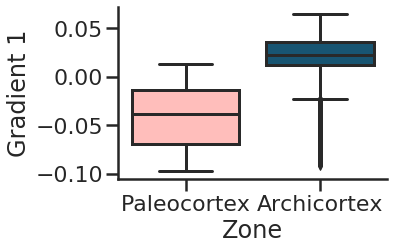

In [16]:
data = pd.DataFrame()
data['Gradient 1'] = np.concatenate((piri_zone, hpc_zone))
data['Zone'] = piri_zone.shape[0] * ['Paleocortex'] + hpc_zone.shape[0] * ['Archicortex']
pal = sns.color_palette([(1, 190/255, 187/255),
                         (24/255, 85/255, 114/255)])

fig = plt.figure()
sns.set_style('ticks')
sns.set_context('poster')
sns.boxplot(x="Zone", y="Gradient 1",data=data, palette=pal, saturation=1)
sns.despine()
plt.tight_layout()
plt.yticks([-0.1, -0.05, 0.0, 0.05])
fig.savefig("/home/julia/data/gradients/pics/zones.svg")

### Statistical energy distance and permutation testing

In [59]:
dist = stats.energy_distance(piri_zone, hpc_zone)

In [38]:
pool = np.concatenate((piri_zone, hpc_zone))

In [57]:
energies = []
for i in range(1000):
    new = np.random.permutation(pool)
    energies.append(stats.energy_distance(new[:piri_zone.shape[0]],new[-hpc_zone.shape[0]:]))

In [79]:
t, p = stats.ttest_1samp(energies, dist, axis=0)

In [80]:
print(dist, t, p)

0.257915553209 -4833.92007771 0.0


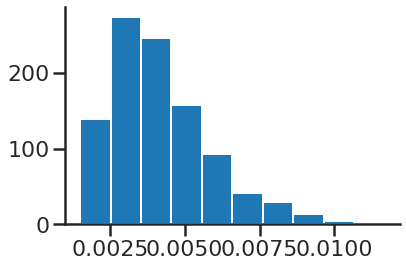

In [77]:
plt.hist(energies)
sns.despine()